In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from src.env.DunderBotEnv import DunderBotEnv
import src.run as run
import src.load as load

loading config from config/config.yml
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# TODO:

- setup train/test functionality (separate reset functions? Multiple time periods for testing?)
- figure out how to normalize values properly
    * do we have to account for prediction as well? That is, can/should we predict using values outside of 0-1 range?
- normalize the action space?
- understand the rendering during learning
- Change policy network (need to understand terminology surronding it, e.g. envoronment, n_steps etc). See also discussion here (and elsewhere among Issues: https://github.com/hill-a/stable-baselines/issues/759)
- Check/Enable/Add exploration noise (for PPO2, use the entropy flag), use https://stable-baselines.readthedocs.io/en/master/common/schedules.html
- lock down the seeds (and decide in config from a few specific ones)
- setup performance output, what we need to make data driven decision
    *e.g. https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/master/1_getting_started.ipynb#scrollTo=63M8mSKR-6Zt
- Add benchmarks
- Add checks and tests
- Find as long time series of BTCUSD hourly data as possible, quite shortright now
- Add finer temporal resolution in data (generate/download multiple granularity)
- Check float number type
- self.stationarize_rewards?
- Enable saveing/loading trained models


# DONE: 
- add config
- modularize rewards
- own actions
- add more detailed actions for buy and sell amounts (still Discrete, I believe)
- wrap running code in function in main.py (to enable more dynamic data loading and train/test)
- own observations
- remove the bias when getting the observations (suggestion in the repo issues)
- download more interesting data and manually preprocess
- load interesting data, specified in config
- understand the time steps in learn and predict
- setup basic monitoring of training using TensorBoard
- Visualize basic performance
- Add support for fractions of shares
- Understand what should belong in what timestep (also decide on which price to plot as a result)
- add distributions of actions as output during prediction
- Refactor `_take_action` (might be something off in some calculations, also update terminology)
- Add commission and slippage
- Refactor current reward and add some new ones
- Add smallest amount of bitcoin we can own, as well as trading precision
- Add portfolio features
- Add reward output

# Run

In [3]:
%%time
df = load.load_OHLC_data()
env = run.preprocess(df=df)
model = run.train(env=env, total_timesteps=1000)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




TRAIN
---------------------------------------
| approxkl           | 3.39094e-06    |
| clipfrac           | 0.0            |
| explained_variance | -0.0525        |
| fps                | 109            |
| n_updates          | 1              |
| policy_entropy     | 2.1972213      |
| policy_loss        | -0.00044502376 |
| serial_timesteps   | 128            |
| time_elapsed       | 5.48e-05       |
| total_timesteps    | 128            |
| value_loss         | 3.4457724e-05  |
---------------------------------------
CPU times: user 9.42 s, sys: 650 ms, total: 10.1 s
Wall time: 9.38 s


TEST
20000 20050
['2019-10-12T19:00:00.000000000' '2019-10-12T20:00:00.000000000'
 '2019-10-12T21:00:00.000000000' '2019-10-12T22:00:00.000000000'
 '2019-10-12T23:00:00.000000000' '2019-10-13T00:00:00.000000000'
 '2019-10-13T01:00:00.000000000' '2019-10-13T02:00:00.000000000'
 '2019-10-13T03:00:00.000000000' '2019-10-13T04:00:00.000000000'
 '2019-10-13T05:00:00.000000000' '2019-10-13T06:00:00.000000000'
 '2019-10-13T07:00:00.000000000' '2019-10-13T08:00:00.000000000'
 '2019-10-13T09:00:00.000000000' '2019-10-13T10:00:00.000000000'
 '2019-10-13T11:00:00.000000000' '2019-10-13T12:00:00.000000000'
 '2019-10-13T13:00:00.000000000' '2019-10-13T14:00:00.000000000'
 '2019-10-13T15:00:00.000000000' '2019-10-13T16:00:00.000000000'
 '2019-10-13T17:00:00.000000000' '2019-10-13T18:00:00.000000000'
 '2019-10-13T19:00:00.000000000' '2019-10-13T20:00:00.000000000'
 '2019-10-13T21:00:00.000000000' '2019-10-13T22:00:00.000000000'
 '2019-10-13T23:00:00.000000000' '2019-10-14T00:00:00.000000000'
 '2019-1

ValueError: x and y must have same first dimension, but have shapes (50,) and (0,)

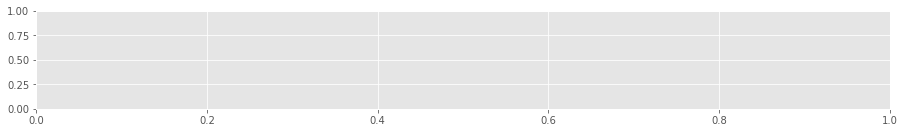

In [5]:
%%time
run.predict(df=df, model=model, total_timesteps=50, rendermode='human')

In [6]:
import pickle
with open('all_dict_pred.pickle', 'rb') as f:
    x = pickle.load(f)
x

{'current_step': 20050,
 'net_worths': [10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  10000.0,
  9984.73,
  10003.95,
  10016.35,
  10012.43,
  10013.72,
  10012.37,
  10004.5,
  9989.81,
  10006.99,
  10024.03,
  10021.76,
  10016.93,
  10045.38,
  10096.39,
  10111.73,
  10109.03,
  10105.68,
  10112.67,
  10107.68,
  10106.56,
  10120.24,
  9965.47,
  9957.93,
  9992.07,
  9989.54,
  9986.79,
  10001.7,
  10005.58,
  9997.14,
  9991.67,
  10008.57,
  10011.08,
  10007.97,
  10010.31,
  10007.54,
  10012.68,
  9991.07,
  9971.8,
  9994.56,
  9973.86,
  9969.0,
  10010.67,
  10010.17,
  10028.88,
  10013.1,
  10014.37],
 'trades': [{'step': 20000,
   'amount': None,
   'total': None,
   'type': 'hold',
   'action_amount': None},
  {'step': 20002,
   'amount': None,
   'total': None,
   'type': 'hold',
   'action_amount': None},
  {'step': 20003,
   'amount': 0.59991673,
   'total': 5000.0,
   'type':

In [8]:
x['net_worths']

[10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 10000.0,
 9984.73,
 10003.95,
 10016.35,
 10012.43,
 10013.72,
 10012.37,
 10004.5,
 9989.81,
 10006.99,
 10024.03,
 10021.76,
 10016.93,
 10045.38,
 10096.39,
 10111.73,
 10109.03,
 10105.68,
 10112.67,
 10107.68,
 10106.56,
 10120.24,
 9965.47,
 9957.93,
 9992.07,
 9989.54,
 9986.79,
 10001.7,
 10005.58,
 9997.14,
 9991.67,
 10008.57,
 10011.08,
 10007.97,
 10010.31,
 10007.54,
 10012.68,
 9991.07,
 9971.8,
 9994.56,
 9973.86,
 9969.0,
 10010.67,
 10010.17,
 10028.88,
 10013.1,
 10014.37]

# Traintest TODO:
- Render function TradingCHartStatic must support other start than 0. Most convenient ways I can think of:
    * to convert the lists containing data to Series with dynamic index (might need to use something else that Slice, dunno if that's compatible with pandas data types.
    * to pad the list in TradingChartStatic. This will require also to cut the padded values out in plotting, which I believe will be simpler in the first option.
- Make sure the overlap is 0
- Set the logic for calculating breking point date from config info
- Pad with data__n_timesteps also for test data to ensure no indirect overlap

# Testing traintest wrapper

In [ ]:
%%time
df = load.load_OHLC_data()
env = run.preprocess(df=df, train_test='train')
model = run.train(env=env, total_timesteps=10000)

In [ ]:
# Here we create the environment directly because gym.make() already wrap the environement in a TimeLimit wrapper otherwise
env = PendulumEnv()
# Wrap the environment
env = TimeLimitWrapper(env, max_steps=100)

In [ ]:
obs = env.reset()
done = False
n_steps = 0
while not done:
  # Take random actions
  random_action = env.action_space.sample()
  obs, reward, done, info = env.step(random_action)
  n_steps += 1

print(n_steps, info)